# Import Libraries

In [1]:
# Import libraries
import time as t
import matplotlib.pyplot as plt

# Part 1:

### Proposition 1:
    Si µ < min16i6r ni (c’est l’hypothèse que l’on a fait à l’origine sur l’encodage du message), et si e 6 r , on peut retrouver µ à partir de c1,...,cr en effectuant un nombre d’opérations polynomial en log(n)

In [2]:
def trouver_mu(c_values, n_values, e):
    # Utilisation du Théorème des Restes Chinois pour trouver x
    x = crt(c_values, n_values)

    # Calcul de la racine e-ème de x (x est une puissance parfaite de e)
    mu = x.nth_root(e)

    return mu

## I need to add smthg to calculate the complexity!!

In [3]:
## Test
e = 3
mu = 36
r = 15  #(e < r)

N = [next_prime(2^30)]
C = [ZZ(Zmod(N[0])(mu^e))]

for i in range(1, r):
    next_p = next_prime(N[i-1])
    while (next_p - 1) % 3 == 0:   # cette condi est rajoutée pour verifier que idéalement e= 3 a besoin de min de temps d'exécution
        next_p = next_prime(next_p)
    
    N.append(next_p)
    C.append(ZZ(Zmod(N[i])(mu^e))) 

# print(len(C),len(N))
#     n*=N[i] n est le produits des n_i

mu = trouver_mu(C, N, e)
mu

36

### Méthode de calcul de la racine e-ième d’un nombre:
    Calcul de complexité binaire 

In [4]:
# SHOWS THE FACT THAT IT DIDN4T CONVERGE

def newton_method_e_root(x, e, tolerance=1e-10, max_iterations=100):
    if x < 0 and e % 2 == 0:
        raise ValueError("Negative number cannot have an even root")

    y = x
    iterations = 0  # Compteur d'itérations
    history = []  # Pour suivre l'évolution de y à chaque itération

    for _ in range(max_iterations):
        y_prev = y
        y = y - (y**e - x) / (e * y**(e-1))
        history.append(y)
        iterations += 1  # Incrémenter le compteur

        # Vérifier la convergence
        if abs(y - y_prev) < tolerance:
            break

    return y, iterations, history  # Retourner la valeur approchée, le nombre d'itérations et l'historique

# Exécuter la fonction pour x = 8 et e = 3 (racine cubique)
racine, iterations, history = newton_method_e_root(27, 3)

# racine, iterations, history[:10]  # Afficher les 10 premières itérations pour l'analyse

racine

1942873625143936294470898417276960244777773331901426610713321580402852997095626882728960513530613062645500056930694400186079639632111165707510666075498433942641493971516299748123739563447152219194778961667083407369359307153559502968793087616105585830096961680359638811095490238272642770633300728183708261495690672439175073470805523331270027489868162562021105804830832932655975397613883959466986959930878237399378732745781895336659917356505474001298679996890388840860704224416013290221153228471823475803919902597645734867188015454002460834677341085631816575875259892149638643754732099494930614875917517119240401414488646572289333555446503327749988171022673775928280319954681034232802865652791679945155498713126875342359018339539668729494519987671947716018470598432706794068348825683604312765919926098913083740380274681877960631905185232762108345154335389973082050050262621255832462568007647356380549610150272741052923466138311314490691332415191339031061454444845271951995505693154925868295610820736384

In [5]:
def newton_method_e_root(x, e, initial_guess=None, tolerance=1e-10, max_iterations=100):
    if x < 0 and e % 2 == 0:
        raise ValueError("Negative number cannot have an even root")

    if initial_guess is None:
        y = x / 2  # Choix d'une valeur initiale par défaut
    else:
        y = initial_guess

    iterations = 0
    history = []

    for _ in range(max_iterations):
        y_prev = y
        y = y - (y**e - x) / (e * y**(e-1))
        history.append(y)
        iterations += 1

        if abs(y - y_prev) < tolerance:
            break

    return y, iterations, history

# Exécuter la fonction avec différentes valeurs initiales pour y
initial_guesses = [1.0, 2.0, 5.0]
results = []

for guess in initial_guesses:
    racine, iterations, history = newton_method_e_root(8, 3, initial_guess=guess)
    results.append((racine, iterations, history[:10]))

results

[(2.00000000000000,
  7,
  [3.33333333333333,
   2.46222222222222,
   2.08134124767158,
   2.00313749914129,
   2.00000491167550,
   2.00000000001206,
   2.00000000000000]),
 (2.00000000000000, 1, [2.00000000000000]),
 (2.00000000000000,
  7,
  [3.44000000000000,
   2.51868036776636,
   2.09948144044716,
   2.00463935741311,
   2.00001072862957,
   2.00000000005755,
   2.00000000000000])]

### Pouquoi e = 3, 257, 65537

In [6]:
# Methode d'exponentiation modulaire rapide

def modular_exponentiation(M, e, n):
    # Initialisation
    R = 1

    # Décomposition Binaire de l'Exposant
    binary_e = bin(e)[2:]

    # Itération sur Chaque Bit de l'Exposant
    for bit in binary_e:
        R = (R * R) % n  # Toujours effectuer un carré
        if bit == '1':
            R = (R * M) % n  # Multiplier si le bit courant est 1

    return R

def is_prime_with_phi(e, phi_n):
    """ Vérifie si 'e' est premier avec 'φ(n)'."""
    return gcd(e, phi_n) == 1

def find_suitable_e_values(phi_n, min_value, max_value):
    """ Trouve les valeurs de 'e' appropriées pour RSA dans la plage donnée."""
    suitable_e_values = []
    for e in range(min_value, max_value, 2):  # Parcourir seulement les nombres impairs
        if is_prime_with_phi(e, phi_n):
            suitable_e_values.append(e)
    return suitable_e_values

def count_bits(n):
    # Compte le nombre de bits à 1 dans la représentation binaire de n
    return bin(n).count('1')

In [7]:
mu = 36
n = 1
r = 15
phi_n = 1
res = []

for i in range(1,r):
    n *= N[i]
    phi_n *= (N[i] - 1) 
    
for e in find_suitable_e_values(phi_n,3 , 65539):
    bits_count = count_bits(e)
    start_time = t.time()
    modular_exponentiation(mu, e, n)
    end_time = t.time()
    execution_time = end_time - start_time
    res.append((e, execution_time, bits_count))

res.sort(key=lambda x: (x[1], x[2]))  #Triée par execution_time, puis par bits_count (complexité)

# Afficher ou utiliser les meilleurs résultats
# Par exemple, afficher les 5 meilleurs
for e, time, bits in res[:6]:
    print(f"e = {e}, Temps d'exécution: {time} µs, Bits à 1: {bits}")

    
# Output:
# e = 37, Temps d'exécution: 1.430511474609375e-06 µs, Bits à 1: 3
# e = 73, Temps d'exécution: 1.430511474609375e-06 µs, Bits à 1: 3
# e = 67, Temps d'exécution: 1.6689300537109375e-06 µs, Bits à 1: 3
# e = 71, Temps d'exécution: 1.6689300537109375e-06 µs, Bits à 1: 4
# e = 89, Temps d'exécution: 1.6689300537109375e-06 µs, Bits à 1: 4
# e = 31, Temps d'exécution: 1.6689300537109375e-06 µs, Bits à 1: 5

e = 37, Temps d'exécution: 1.6689300537109375e-06 µs, Bits à 1: 3
e = 73, Temps d'exécution: 2.1457672119140625e-06 µs, Bits à 1: 3
e = 61, Temps d'exécution: 2.1457672119140625e-06 µs, Bits à 1: 5
e = 67, Temps d'exécution: 2.384185791015625e-06 µs, Bits à 1: 3
e = 71, Temps d'exécution: 2.384185791015625e-06 µs, Bits à 1: 4
e = 89, Temps d'exécution: 2.384185791015625e-06 µs, Bits à 1: 4


In [69]:
## I need to generate e that are 1er with phi_n(), then plot them but good ta9adom!!


# Code to create a list of e values with a fixed length and increasing number of '1's, and then test modular exponentiation

# My genearted e should be 1er with phi_n()
def generate_e_values_prime_with_phi(length, phi):
    """Generates e values with a specific binary length, prime relative to phi, and only one example per number of 1s in the binary representation."""
    e_values = []
    seen_ones_count = set()  # A set to keep track of the count of 1's we've seen
    
    # Iterate over all possible binary numbers of the given length
    start = 2**(length - 1)  # Smallest number with 'length' bits
    end = 2**length          # One past the largest number with 'length' bits

    for e in range(start, end):
        ones_count = bin(e).count('1')
        # Check if we have already seen this count of 1's
        if ones_count in seen_ones_count:
            continue  # Skip this number if we have

        # Check if e is prime relative to phi
        if gcd(e, phi) == 1:
            e_values.append(e)
            seen_ones_count.add(ones_count)  # Mark this count of 1's as seen

    return e_values


def test_execution_time(M, n, e_values):
    """Tests the execution time for each e value."""
    results = []
    for e in e_values:
        start_time = t.time()
        r = modular_exponentiation(M, e, n)
        end_time = t.time()
        time_taken = end_time - start_time
        one_count = bin(e).count('1')
        results.append((e, one_count, time_taken))
    return results

In [99]:
e = 3
mu = 36
r = 15  #(e < r)
phi_n = 1


N = [next_prime(2^30)]
C = [ZZ(Zmod(N[0])(mu^e))]

for i in range(1, r):
    next_p = next_prime(N[i-1])
    while (next_p - 1) % 3 == 0:   # cette condi est rajoutée pour verifier que idéalement e= 3 a besoin de min de temps d'exécution
        next_p = next_prime(next_p)
    
    N.append(next_p)
    C.append(ZZ(Zmod(N[i])(mu^e)))

for i in range(1,r):
#     n *= N[i]
    phi_n *= (N[i] - 1) 

e_val = generate_e_values_prime_with_phi(17, phi_n)
# e_val = [item for item in e_val if item != 65537]
# e_val = e_val.append(65539)

resu = test_execution_time(mu, n, e_val)


# print(f'▶️e_val ', e_val)
print(f'▶️ resu ', resu)


▶️ resu  [(65537, 2, 2.5033950805664062e-05), (65539, 3, 1.0251998901367188e-05), (65543, 4, 9.5367431640625e-06), (65551, 5, 9.298324584960938e-06), (65567, 6, 9.775161743164062e-06), (65599, 7, 9.775161743164062e-06), (65727, 8, 1.0013580322265625e-05), (65983, 9, 1.0251998901367188e-05), (66047, 10, 1.049041748046875e-05), (67071, 11, 1.049041748046875e-05), (69119, 12, 1.0967254638671875e-05), (69631, 13, 1.1205673217773438e-05), (73727, 14, 1.1205673217773438e-05), (81919, 15, 1.1444091796875e-05), (98303, 16, 1.1920928955078125e-05), (131071, 17, 1.1920928955078125e-05)]


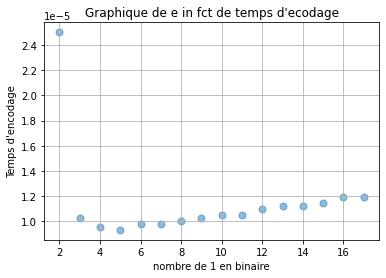

In [100]:
# Séparation des données en deux listes: une pour la première partie du tuple, l'autre pour la troisième
x = [item[1] for item in resu]  # première partie du tuple
y = [item[2] for item in resu]  # troisième partie du tuple

# Création du graphique
# Assuming x and y are defined as in your initial code
# plt.scatterplot(x, y, marker='o')  # This seems to be a typo, as matplotlib uses plt.scatter

plt.scatter(x, y, s=50, alpha=0.5)  # s is the size, alpha is the transparency level
plt.xlabel('nombre de 1 en binaire')
plt.ylabel('Temps d\'encodage')
plt.title('Graphique de e in fct de temps d\'ecodage')
plt.grid(True)
plt.show()

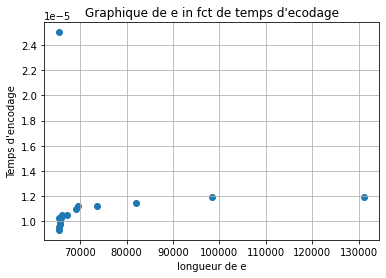

In [101]:
# Séparation des données en deux listes: une pour la première partie du tuple, l'autre pour la troisième
x = e_val  # première partie du tuple
y = [item[2] for item in resu]  # troisième partie du tuple

# Création du graphique
plt.scatter(x, y, marker='o')
plt.xlabel('longueur de e')
plt.ylabel('Temps d\'encodage')
plt.title('Graphique de e in fct de temps d\'ecodage')
plt.grid(True)
plt.show()